# NO SMOKE brightness temperature 
- using the data from laura that I downloaded with the brightness temperature script 
- download data in terminal 
- to get different days, have to change the script 

## No Smoke Case
- June 15 18 - 23 UTC 
- 110o W → 117o W
- 53o C→ 60o N 
- T-storm traveling quickly


# imports

In [2]:
import os
import awscli as aws
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date 
from datetime import time
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely import geometry

import matplotlib.pyplot as plt
import xarray 
import scipy.stats as ss 
import metpy  
import os
import h5py    
from pyhdf import SD
from mpl_toolkits.basemap import Basemap
import colormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import time
import calendar
from matplotlib.patches import Polygon
from netCDF4 import Dataset # Import the NetCDF Python interface
import netCDF4 as nc
import geopandas as gpd
from shapely.geometry import Point, Polygon
import bottleneck
import shapely
import dask
import nco
from sklearn.neighbors import NearestNeighbors
from math import radians, cos, sin, asin, sqrt
from textwrap import wrap
import matplotlib.patches as mpatches


# functions

## convert x/y to lat/lon with netcdf : project_abi(ds)

In [3]:
#FUNCTION:

#IN: an nc dataset from GOES
#OUT LAT/LON in the right projection
def project_abi(ds): #grid edges
    # grab the constants needed to do the projection from GOES grid to lat/lon
    Req = ds.variables['goes_imager_projection'].semi_major_axis
    Rpol = ds.variables['goes_imager_projection'].semi_minor_axis
    lambda_0 = ds.variables['goes_imager_projection'].longitude_of_projection_origin
    lambda_0 = lambda_0*math.pi/180
    Hsat = ds.variables['goes_imager_projection'].perspective_point_height
    H = Hsat+Req
    # projection from GOES grid to lat/lon, following https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    lat_rad_1d = ds['x'][:]
    lon_rad_1d = ds['y'][:]
    [X, Y] = np.meshgrid(lat_rad_1d, lon_rad_1d) # lon is x, lat is y, uses 'xy' indexing by default

    # sin and cos of x and y
    sinx = np.sin(X)
    sinx2 = sinx**2
    siny = np.sin(Y)
    siny2 = siny**2
    cosx = np.cos(X)
    cosx2 = cosx**2
    cosy = np.cos(Y)
    cosy2 = cosy**2

    a = np.power(np.sin(X),2.0) + (np.power(np.cos(X),2.0)*(np.power(np.cos(Y),2.0)+(((Req*Req)/(Rpol*Rpol))*np.power(np.sin(Y),2.0))))
    b = -2.0*H*np.cos(X)*np.cos(Y)
    c = (H**2.0)-(Req**2.0)

    # calculate rs
    rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a

    # calculate sx, sy, sz
    sx = rs*cosx*cosy
    sy = -rs*sinx
    sz = rs*cosx*siny
       
    # calculate lat and lon
    test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))
    lat = np.arctan(test)
    lon = lambda_0 - np.arctan(sy/(H-sx)) # in radians

    lat_deg = lat*180/math.pi
    lon_deg = lon*180/math.pi

    return lat_deg, lon_deg

In [4]:
#Here is the function, you can use it like this: 

ds= nc.Dataset('/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc')
ds_lat, ds_lon = project_abi(ds)
#np.unique(ds_lat.data)
np.unique(ds_lon)

/tmp/ipykernel_145039/1134369174.py:33: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a
/tmp/ipykernel_145039/1134369174.py:41: RuntimeWarning: invalid value encountered in sqrt
  test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))


masked_array(data=[-218.27157592773438, -218.26223754882812,
                   -218.18772888183594, ..., -55.73775100708008,
                   -55.72842025756836, --],
             mask=[False, False, False, ..., False, False,  True],
       fill_value=1e+20,
            dtype=float32)

## covert x/y to lat/lon with xarray : calc_latlon(ds)

In [5]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
        
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"
    return ds

In [6]:
ds= xarray.open_dataset('/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc')
ds_latlon = calc_latlon(ds)
ds_latlon

/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    lat                                     (y, x) float32 nan nan ... nan nan
    lon                                     (y, x) float32 nan nan ... nan nan
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-15T18:59:54.1Z
    time_coverage_start:       2021-06-15T18:50:32.1Z
    time_coverage_end:         2021-06-15T18:59:39.9Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        66d60150-f282-48d3-a7eb-f7420a68334e

In [7]:
np.unique(ds_latlon["lat"][:])

array([-81.15669, -81.09764, -81.06229, ...,  81.09764,  81.15669,
             nan], dtype=float32)

## grid cell corners: calculate_grid_cell_corners(LAT, LON)

In [8]:
#LAT and LON are 2d arrays
# finds the grid cell corners to make the boxes 
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [9]:
# plug in the transformed lat and lon into grid corners 
grid_corners = calculate_grid_cell_corners(ds_latlon["lat"][:], ds_latlon["lon"][:])
#np.unique(grid_corners[0])
#grid_unique = grid_corners[~np.isnan(grid_corners)]
grid_corners
#returns [0] as lat_corners, [1] as lon_corners 

(<xarray.DataArray 'lat' (y: 5422, x: 5422)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * y        (y) float64 0.1518 0.1517 0.1517 0.1516 ... -0.1517 -0.1517 -0.1518
   * x        (x) float64 -0.1518 -0.1517 -0.1517 ... 0.1517 0.1517 0.1518
     t        datetime64[ns] 2021-06-15T18:55:06.059201024
     y_image  float32 0.0
     x_image  float32 0.0
     lat      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
     lon      (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan,
 <xarray.DataArray 'lon' (y: 5422, x: 5422)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan,

## haversine - dist

In [10]:
def dist(lat1, long1, lat2, long2):
    """
Replicating the same formula as mentioned in Wiki
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

## haversine - distance between points

In [11]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km


# packages

## net cdf

In [12]:
fn = '/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc'
ds = nc.Dataset(fn)
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 2km at nadir
    orbital_slot: GOES-West
    platform_ID: G17
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Full Disk
    instrument_ID: FM2
    dataset_name: OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc
    iso_series_metadata_id: 8c9e8150-3692-11e3-aa6e-0800200c9a66
    keywords_vocabulary: NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0
    titl

In [13]:
print(ds.__dict__)

{'naming_authority': 'gov.nesdis.noaa', 'Conventions': 'CF-1.7', 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0', 'standard_name_vocabulary': 'CF Standard Name Table (v35, 20 July 2016)', 'institution': 'DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services', 'project': 'GOES', 'production_site': 'NSOF', 'production_environment': 'OE', 'spatial_resolution': '2km at nadir', 'orbital_slot': 'GOES-West', 'platform_ID': 'G17', 'instrument_type': 'GOES R Series Advanced Baseline Imager', 'scene_id': 'Full Disk', 'instrument_ID': 'FM2', 'dataset_name': 'OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc', 'iso_series_metadata_id': '8c9e8150-3692-11e3-aa6e-0800200c9a66', 'keywords_vocabulary': 'NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 7.0.0.0.0', 'title': 'ABI L2 Cloud and Moisture Imagery', 'summary': 'Multiple reflectan

In [14]:
print(ds['CMI_C14'])


<class 'netCDF4._netCDF4.Variable'>
int16 CMI_C14(y, x)
    _FillValue: -1
    long_name: ABI Cloud and Moisture Imagery brightness temperature at top of atmosphere
    standard_name: toa_brightness_temperature
    _Unsigned: true
    sensor_band_bit_depth: 12
    valid_range: [   0 4095]
    scale_factor: 0.05985075
    add_offset: 96.19
    units: K
    resolution: y: 0.000056 rad x: 0.000056 rad
    coordinates: band_id_C14 band_wavelength_C14 t y x
    grid_mapping: goes_imager_projection
    cell_methods: t: point area: point
    ancillary_variables: DQF_C14
unlimited dimensions: 
current shape = (5424, 5424)
filling on


In [15]:
CMI_C14 = ds['CMI_C14'][:]
CMI_C14

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=65535,
  dtype=float32)

## geopandas polygon
- Spatial overlays is the process of overlaying two or more layers on top of each other and performing operations based on how they overlay


In [16]:
p1 = Point(24.5, 60.5)
p2 = Point(25.5, 61.5)

# Create a Polygon
coords = [(25, 60), (24, 60), (24, 61), (25, 61)]
poly1 = Polygon(coords)

In [17]:
gdf_points = gpd.GeoDataFrame(geometry=[p1,p2])
gdf_poly = gpd.GeoDataFrame(geometry=[poly1])

<AxesSubplot:>

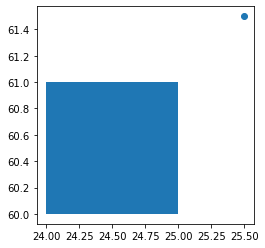

In [18]:
fig, ax1 = plt.subplots()
gdf_poly.plot(ax=ax1)
gdf_points.plot(ax = ax1)

In [19]:
p1.within(poly1)

True

In [20]:
poly1.contains(p1)

True

# import GOES files 
OR_ABI-L2-MCMIPC-M3_G16_s20181781922189_e20181781924562_c20181781925075.nc

OR - Indicates the system is operational

ABI - Instrument type

L2 - Level 2 Data

MCMIP - Multichannel Cloud and Moisture Imagery products

c - CONUS file (created every 5 minutes).

M3 - Scan mode

G16 - GOES-16

sYYYYJJJHHMMSSZ - Scan start: 4 digit year, 3 digit day of year (Julian day), hour, minute, second, tenth second

eYYYYJJJHHMMSSZ - Scan end

cYYYYJJJHHMMSSZ - File Creation .nc - NetCDF file extension

In [12]:
# data/edworak/202118205/OR_ABI-L2-MCMIPF-M6_G17_s20211820520320_e20211820529392_c20211820529542.nc
path = '/data2/edworak/data/BT_nosmoke'
list_foldernames = os.listdir(path)
list_filenames = os.listdir('/data2/edworak/data/BT_nosmoke/202116623')
print(list_foldernames) 
print(list_filenames)

['download_bt_nosmoke', '202116618', '202116619', '202116620', '202116621', '202116622', '202116623']
['OR_ABI-L2-MCMIPF-M6_G17_s20211662310319_e20211662319397_c20211662319542.nc', 'OR_ABI-L2-MCMIPF-M6_G17_s20211662330319_e20211662339392_c20211662339544.nc', 'OR_ABI-L2-MCMIPF-M6_G17_s20211662340319_e20211662349397_c20211662349541.nc', 'OR_ABI-L2-MCMIPF-M6_G17_s20211662300319_e20211662309391_c20211662309541.nc', 'OR_ABI-L2-MCMIPF-M6_G17_s20211662320319_e20211662329397_c20211662329540.nc', 'OR_ABI-L2-MCMIPF-M6_G17_s20211662350319_e20211662359391_c20211662359541.nc']


In [13]:
FILE = '/data2/edworak/data/BT_nosmoke/202116618/OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc'
# FILE = path + file_names[i]
data = xarray.open_dataset(FILE)
goes_data = data['CMI_C14'][:]
goes_data

<xarray.DataArray 'CMI_C14' (y: 5424, x: 5424)>
[29419776 values with dtype=float32]
Coordinates:
    t        datetime64[ns] ...
  * y        (y) float32 0.1518 0.1518 0.1517 0.1517 ... -0.1517 -0.1518 -0.1518
  * x        (x) float32 -0.1518 -0.1518 -0.1517 ... 0.1517 0.1518 0.1518
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    long_name:              ABI Cloud and Moisture Imagery brightness tempera...
    standard_name:          toa_brightness_temperature
    sensor_band_bit_depth:  12
    valid_range:            [   0 4095]
    units:                  K
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: point
    ancillary_variables:    DQF_C14

## folder names

In [14]:
# create empty array to add into 
folder_names_unsorted = []
path = '/data2/edworak/data/BT_nosmoke'
folder = os.listdir(path)
#print(file)

for f in folder[1:]: 
    folder_names_unsorted.append(f)
folder_names = sorted(folder_names_unsorted)
folder_names

['202116618', '202116619', '202116620', '202116621', '202116622', '202116623']

## file names

In [15]:
file_names_unsorted = []
for i in range(0, len(folder_names)): 
    path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i]
    #print(path)
    file = os.listdir(path)
    file_names_unsorted.append(file)
file_names = sorted(file_names_unsorted)
# file_names = [item for sublist in file_names_unsorted for item in sublist]
file_names[0][0]

'OR_ABI-L2-MCMIPF-M6_G17_s20211661810321_e20211661819388_c20211661819542.nc'

## download files

In [16]:
goes_data = []

for i in range(0, len(folder_names), 1):
    for j in range(0, 6, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        goes_data = xarray.open_dataset(FILE)
goes_data

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/37)
    t                                       datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C11                             (band) int8 ...
    band_id_C12                             (band) int8 ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/124)
    CMI_C01                                 (y, x) float32 ...
    DQF_C01                                 (y, x) float32 ...
    CMI_C02                                 (y, x) float32 ...
    DQF_C02                                 (y, x) float32 ...
    CMI_C03                                 (y, x) float32 ...
    DQF_C03                                 (y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         float32 ...
    std_dev_brightness_temperature_C16      float32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    dynamic_algorithm_input_data_container  int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-15T23:59:54.1Z
    time_coverage_start:       2021-06-15T23:50:31.9Z
    time_coverage_end:         2021-06-15T23:59:39.1Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        f36cb978-e0b6-4593-90d6-12c3404b755d

In [ ]:
goes_data['CMI_C14'][:]


# manipulate data: select by time, region, brightness temperature

## folder and file names

In [21]:
# path to file 

# create empty array to add into 
folder_names_unsorted = []
path = '/data2/edworak/data/BT_nosmoke/'
folder = os.listdir(path)

for f in folder: 
    folder_names_unsorted.append(f)
folder_names = sorted(folder_names_unsorted)
print(len(folder_names_unsorted))
folder_names


7


['202116618',
 '202116619',
 '202116620',
 '202116621',
 '202116622',
 '202116623',
 'download_bt_nosmoke']

In [22]:
file_names_unsorted = []

for i in range(len(folder_names[:-1])): 
    file = os.listdir(path + folder_names[i])
    file_names_unsorted.append(file)
file_names = sorted(file_names_unsorted)
file_names

[['OR_ABI-L2-MCMIPF-M6_G17_s20211661810321_e20211661819388_c20211661819542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661830321_e20211661839399_c20211661839541.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661820321_e20211661829388_c20211661829542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661840321_e20211661849388_c20211661849540.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661850321_e20211661859399_c20211661859541.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661800321_e20211661809388_c20211661809541.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G17_s20211661920321_e20211661929399_c20211661929539.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661910321_e20211661919399_c20211661919542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661930321_e20211661939399_c20211661939540.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661940321_e20211661949388_c20211661949542.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661900321_e20211661909388_c20211661909539.nc',
  'OR_ABI-L2-MCMIPF-M6_G17_s20211661950321_e20211661959393_c20211661959543.nc'],
 ['OR_ABI-L2-MCMIPF-M6_G17_s2021166200

## merge all netcdf files by time

In [24]:
#File = "/data/edworak/BT_nosmoke/202116618/*.nc"
# ds_18 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116618/*.nc", combine = 'nested', concat_dim="time")
# ds_19 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116619/*.nc", combine = 'nested', concat_dim="time")
# ds_20 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116620/*.nc", combine = 'nested', concat_dim="time")
# ds_21 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116621/*.nc", combine = 'nested', concat_dim="time")
# ds_22 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116622/*.nc", combine = 'nested', concat_dim="time")
# ds_23 = xarray.open_mfdataset( "/data/edworak/BT_nosmoke/202116623/*.nc", combine = 'nested', concat_dim="time")

# save this to data directory 

#ds_18.to_netcdf('/data2/edworak/BT_nosmoke_combined/ds_18.nc')
#ds_23.to_netcdf('/data2/edworak/BT_nosmoke_combined/ds_23.nc')

In [25]:
ds_combined = calc_latlon(xarray.open_dataset('/data2/edworak/BT_nosmoke_combined/ds_21.nc'))
ds_combined

/tmp/ipykernel_64665/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.Dataset>
Dimensions:                                 (time: 6, y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates: (12/39)
    t                                       (time) datetime64[ns] ...
  * y                                       (y) float32 0.1518 ... -0.1518
  * x                                       (x) float32 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength_C01                     (band) float32 ...
    ...                                      ...
    band_id_C13                             (band) int8 ...
    band_id_C14                             (band) int8 ...
    band_id_C15                             (band) int8 ...
    band_id_C16                             (band) int8 ...
    lat                                     (y, x) float32 nan nan ... nan nan
    lon                                     (y, x) float32 nan nan ... nan nan
Dimensions without coordinates: time, number_of_time_bounds,
                                number_of_image_bounds, band
Data variables: (12/124)
    CMI_C01                                 (time, y, x) float32 ...
    DQF_C01                                 (time, y, x) float32 ...
    CMI_C02                                 (time, y, x) float32 ...
    DQF_C02                                 (time, y, x) float32 ...
    CMI_C03                                 (time, y, x) float32 ...
    DQF_C03                                 (time, y, x) float32 ...
    ...                                      ...
    mean_brightness_temperature_C16         (time) float32 ...
    std_dev_brightness_temperature_C16      (time) float32 ...
    percent_uncorrectable_GRB_errors        (time) float32 ...
    percent_uncorrectable_L0_errors         (time) float32 ...
    dynamic_algorithm_input_data_container  (time) int32 ...
    algorithm_product_version_container     (time) int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    date_created:              2021-06-15T21:09:54.2Z
    time_coverage_start:       2021-06-15T21:00:32.1Z
    time_coverage_end:         2021-06-15T21:09:38.8Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        007243d4-b737-434f-bdb2-04046e607646

## select lat and lon, convert into celsius
does chat gpt work? 

In [23]:
FILE = '/data2/edworak/BT_nosmoke_combined/ds_21.nc'
# FILE = path + file_names[i]
ds_xy = xarray.open_dataset(FILE)
ds_latlon = calc_latlon(ds_xy)

lat_min, lat_max = 53, 60
lon_min, lon_max = -117, -110

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)
goes_data = selected_region['CMI_C14'][:] - 273.15
goes_data.attrs["units"] = "kelvin"
goes_data

# print unique values only
#np.unique(data_celsius)
goes_data.values

/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


array([[[-47.502823, -47.622528, -47.502823, ...,        nan,
                nan,        nan],
        [       nan, -47.442978, -47.442978, ...,        nan,
                nan,        nan],
        [       nan,        nan, -46.784607, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,  21.684662,
          22.103607,        nan],
        [       nan,        nan,        nan, ...,  21.385406,
          21.325531,  21.684662],
        [       nan,        nan,        nan, ...,  21.205841,
          21.145966,  21.145966]],

       [[-44.091324, -44.62999 , -44.929245, ...,        nan,
                nan,        nan],
        [       nan, -44.151184, -44.151184, ...,        nan,
                nan,        nan],
        [       nan,        nan, -43.133713, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,  21.205841,
          21.385406,        nan],
        [   

## select by brightness temperature < -50 C 

In [24]:
FILE = '/data2/edworak/BT_nosmoke_combined/ds_21.nc'
# FILE = path + file_names[i]
ds_xy = xarray.open_dataset(FILE)

#change x/y into lat/lon 
ds_latlon = calc_latlon(ds_xy)

#select by lat/lon region
lat_min, lat_max = 53, 60
lon_min, lon_max = -117, -110

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

#select CMI_C14 channel anc convert into celsius
goes_data = selected_region['CMI_C14'][:] - 273.15
goes_data.attrs["units"] = "celsius"

#select where brightness temp is below -50 C
bt_condition = (goes_data <= -50)
ds_selected = goes_data.where(bt_condition, drop = True)
ds_selected
# print unique values only
#np.unique(ds_selected)

/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


<xarray.DataArray 'CMI_C14' (time: 6, y: 98, x: 228)>
array([[[-51.093872, -51.213562,        nan, ...,        nan,
                nan,        nan],
        [-51.093872, -52.11133 , -52.231033, ...,        nan,
                nan,        nan],
        [       nan, -51.393127, -52.29088 , ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    t        (time) datetime64[ns] 2021-06-15T21:05:05.520724096 ... 2021-06-...
  * y        (y) float32 0.1395 0.1395 0.1394 0.1394 ... 0.1342 0.1341 0.1341
  * x        (x) float32 0.02803 0.02808 0.02814 ... 0.04063 0.04068 0.04074
    y_image  float32 0.0
    x_image  float32 0.0
    lat      (y, x) float32 59.99 60.0 60.0 60.0 ... 55.84 55.84 55.84 55.84
    lon      (y, x) float32 -116.7 -116.7 -116.6 -116.6 ... -110.6 -110.5 -110.5
Dimensions without coordinates: time
Attributes:
    units:    celsius

## change bt into a dataframe

In [25]:
# if I can load in BT as one data frame, then can just do this process once to compare 
ds_latlon = calc_latlon(xarray.open_dataset('/data2/edworak/BT_nosmoke_combined/ds_21.nc'))

#select by lat/lon region
lat_min, lat_max = 53, 60
lon_min, lon_max = -117, -110

lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

#select CMI_C14 channel anc convert into celsius
goes_data = selected_region['CMI_C14'][:] - 273.15
goes_data.attrs["units"] = "celsius"

#select where brightness temp is below -50 C
# bt_condition = (goes_data <= -50)
# ds_selected = goes_data.where(bt_condition, drop = True)

# Convert the xarray dataarray to a pandas dataframe
df = goes_data.to_dataframe()

df['Date'] = pd.to_datetime(df['t'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute
df['Second'] = df['Date'].dt.second

data = df.loc[:, ("Year","Month","Day", "Hour", "Minute", "Second", "lat", "lon", "CMI_C14")]
data.dropna(inplace = True)

# Add the dataframe to the existing pandas dataframe
#existing_df = pd.read_csv('existing_data.csv')
#result = pd.concat([data_nosmoke, df], axis=1)
data


/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


Year  Month  Day  Hour  Minute  Second        lat  \
time y        x                                                             
0    0.139524 0.027692  2021      6   15    21       5       5  59.977394   
              0.027748  2021      6   15    21       5       5  59.980545   
              0.027804  2021      6   15    21       5       5  59.983234   
              0.027860  2021      6   15    21       5       5  59.986389   
              0.027916  2021      6   15    21       5       5  59.989048   
...                      ...    ...  ...   ...     ...     ...        ...   
5    0.130228 0.044548  2021      6   15    21      55       5  53.046143   
              0.044604  2021      6   15    21      55       5  53.048496   
     0.130172 0.044492  2021      6   15    21      55       5  53.001804   
              0.044548  2021      6   15    21      55       5  53.004604   
              0.044604  2021      6   15    21      55       5  53.007412   

                               lon    CMI_C14  
time y        x                                
0    0.139524 0.027692 -116.979698 -47.502823  
              0.027748 -116.934792 -47.622528  
              0.027804 -116.890244 -47.502823  
              0.027860 -116.845306 -47.742218  
              0.027916 -116.800743 -48.639984  
...                            ...        ...  
5    0.130228 0.044548 -110.047745  21.684662  
              0.044604 -110.008575  21.325531  
     0.130172 0.044492 -110.118774  21.445221  
              0.044548 -110.079216  21.445221  
              0.044604 -110.039612  21.205841  

[159186 rows x 9 columns]

## change brightness temp into dataframe, in for loop

In [33]:
# if I can load in BT as one data frame, then can just do this process once to compare 
datasets = ["ds_18", "ds_19", "ds_20", "ds_21", "ds_22", "ds_23"]
path = '/data2/edworak/BT_nosmoke_combined/'

for i in range(len(datasets)): 
    ds_latlon = calc_latlon(xarray.open_dataset(path + datasets[i] + '.nc'))

    #select by lat/lon region
    lat_min, lat_max = 53, 60
    lon_min, lon_max = -117, -110
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    #select CMI_C14 channel anc convert into celsius
    goes_data = selected_region['CMI_C14'][:] - 273.15
    goes_data.attrs["units"] = "celsius"

    # Convert the xarray dataarray to a pandas dataframe
    df = goes_data.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    bt_hourly_df = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
    
#     bt_hourly_df = pd.DataFrame({"year" : df['Date'].dt.year, "month": df['Date'].dt.month,
#                                  "day": df['Date'].dt.day, "hour": df['Date'].dt.hour,
#                                  "minute":df['Date'].dt.minute, "second": df['Date'].dt.second,
#                                  "CMI_C14": CMI_C14})

    bt_hourly_df.dropna(inplace = True)
    #data.set_index(df['Year'])

    # Add the dataframe to the existing pandas dataframe
    #existing_df = pd.read_csv('existing_data.csv')
    #result = pd.concat([data_nosmoke, df], axis=1)
    if i == 0: 
        bt_df = bt_hourly_df
    if i > 0: 
        bt_df = pd.concat([bt_df, bt_hourly_df], axis =0)
    
    # this is only showing the time of the last iteration 
    # have to either append it or combine all datasets for each hour after the fact 
    # it is only saving the last one 

/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_145039/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [34]:
bt_df.to_csv('/data2/edworak/data/bt_df.nc')
bt_df

# cold_bt_df = bt_df.loc[(bt_df.CMI_C14 < -50)]
# cold_bt_df

year  month  day  hour  minute  second        lat  \
time y        x                                                             
0    0.139524 0.027692  2021      6   15    18       5       5  59.977394   
              0.027748  2021      6   15    18       5       5  59.980545   
              0.027804  2021      6   15    18       5       5  59.983234   
              0.027860  2021      6   15    18       5       5  59.986389   
              0.027916  2021      6   15    18       5       5  59.989048   
...                      ...    ...  ...   ...     ...     ...        ...   
5    0.130228 0.044548  2021      6   15    23      55       5  53.046143   
              0.044604  2021      6   15    23      55       5  53.048496   
     0.130172 0.044492  2021      6   15    23      55       5  53.001804   
              0.044548  2021      6   15    23      55       5  53.004604   
              0.044604  2021      6   15    23      55       5  53.007412   

                               lon    CMI_C14  
time y        x                                
0    0.139524 0.027692 -116.979698  -2.854156  
              0.027748 -116.934792   0.677032  
              0.027804 -116.890244  -1.776855  
              0.027860 -116.845306  -6.026276  
              0.027916 -116.800743  -6.804291  
...                            ...        ...  
5    0.130228 0.044548 -110.047745  19.470184  
              0.044604 -110.008575  19.111053  
     0.130172 0.044492 -110.118774  19.410309  
              0.044548 -110.079216  19.470184  
              0.044604 -110.039612  19.350464  

[955116 rows x 9 columns]

## bt as dataframe, select by bt

In [33]:
# if I can load in BT as one data frame, then can just do this process once to compare 
datasets = ["ds_18", "ds_19", "ds_20", "ds_21", "ds_22", "ds_23"]
path = '/data2/edworak/BT_nosmoke_combined/'

for i in range(len(datasets)): 
    ds_latlon = calc_latlon(xarray.open_dataset(path + datasets[i] + '.nc'))

    #select by lat/lon region
    lat_min, lat_max = 53, 60
    lon_min, lon_max = -117, -110
    lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
    lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
    selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

    #select CMI_C14 channel anc convert into celsius
    goes_data = selected_region['CMI_C14'][:] - 273.15
    goes_data.attrs["units"] = "celsius"

    #select where brightness temp is below -50 C
    bt_condition = (goes_data <= -50)
    ds_selected = goes_data.where(bt_condition, drop = True)
    
    # Convert the xarray dataarray to a pandas dataframe
    df = ds_selected.to_dataframe()
    scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    df['Date'] = pd.to_datetime(df['t'])
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['hour'] = df['Date'].dt.hour
    df['minute'] = df['Date'].dt.minute
    df['second'] = df['Date'].dt.second

    bt_hourly_df_50 = df.loc[:, ("year","month","day", "hour", "minute", "second", "lat", "lon", "CMI_C14")]
    
#     bt_hourly_df = pd.DataFrame({"year" : df['Date'].dt.year, "month": df['Date'].dt.month,
#                                  "day": df['Date'].dt.day, "hour": df['Date'].dt.hour,
#                                  "minute":df['Date'].dt.minute, "second": df['Date'].dt.second,
#                                  "CMI_C14": CMI_C14})

  #  bt_hourly_df.dropna(inplace = True)
    #data.set_index(df['Year'])

    # Add the dataframe to the existing pandas dataframe
    #existing_df = pd.read_csv('existing_data.csv')
    #result = pd.concat([data_nosmoke, df], axis=1)
    if i == 0: 
        bt_df_50 = bt_hourly_df_50
    if i > 0: 
        bt_df_50 = pd.concat([bt_df_50, bt_hourly_df_50], axis =0)
    
    # this is only showing the time of the last iteration 
    # have to either append it or combine all datasets for each hour after the fact 
    # it is only saving the last one 

/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
/tmp/ipykernel_96087/1595082102.py:20: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [34]:
bt_df_50.to_csv('/data2/edworak/data/bt_df_50.nc')
bt_df_50

year  month  day  hour  minute  second        lat  \
time y        x                                                             
0    0.137396 0.031164  2021      6   15    18       5       5  58.168694   
              0.031220  2021      6   15    18       5       5  58.171936   
              0.031276  2021      6   15    18       5       5  58.174339   
              0.031332  2021      6   15    18       5       5  58.177006   
              0.031388  2021      6   15    18       5       5  58.180023   
...                      ...    ...  ...   ...     ...     ...        ...   
5    0.136052 0.039228  2021      6   15    23      55       5  57.420460   
              0.039284  2021      6   15    23      55       5  57.424374   
              0.039340  2021      6   15    23      55       5  57.427105   
              0.039396  2021      6   15    23      55       5  57.430744   
              0.039452  2021      6   15    23      55       5  57.434147   

                               lon  CMI_C14  
time y        x                              
0    0.137396 0.031164 -115.642151      NaN  
              0.031220 -115.599030      NaN  
              0.031276 -115.556610      NaN  
              0.031332 -115.513939      NaN  
              0.031388 -115.470932      NaN  
...                            ...      ...  
5    0.136052 0.039228 -110.269066      NaN  
              0.039284 -110.223480      NaN  
              0.039340 -110.179169      NaN  
              0.039396 -110.133812      NaN  
              0.039452 -110.088707      NaN  

[792612 rows x 9 columns]

# import vaisala lightning data

## load in the data

In [17]:
data = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["a", "c", "Date", "e", "lon", "i", "peak-current", "lat", "m", "n", "o", "polarity", "range", "signal", "time", "u", "v", "z", "A", "C", "E", "C or G", "mag_current", "lat2", "m2", "time_nano", "R", "S", "T", "latlon"], delim_whitespace = True, skiprows = 0)
data2 = pd.read_csv("/data2/edworak/data/2021_2022_acdegiklmnoprstuvzACEGKLMNRST4_sc.txt", names = ["Date", "lon","peak-current", "lat", "multi", "polarity", "range", "Time", "C or G" ], delim_whitespace = True, skiprows = 0, usecols = [3,5,7,9,10,13,14,17,24])
data2[["year", "month", "day"]] = data2["Date"].str.split("-", expand = True)
data2[["hour", "minute", "second"]] = data2["Time"].str.split(":", expand = True)
data2['year'] = data2['year'].astype('int')
data2['month'] = data2['month'].astype('int')
data2['day'] = data2['day'].astype('int')
data2['hour'] = data2['hour'].astype('int')
data2['minute'] = data2['minute'].astype('int')
data_split2 = data2[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G", "multi", "polarity", "range"]]

data_split2

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,multi,polarity,range
0,2021,6,2,22,15,39,58.073,-119.732,14.7,C,0,+,11817.95
1,2021,6,2,22,15,40,58.043,-119.737,12.2,C,0,+,11819.49
2,2021,6,2,22,19,23,58.060,-118.448,-40.3,G,0,-,11818.65
3,2021,6,2,22,19,23,58.060,-118.449,-22.4,G,0,-,11818.65
4,2021,6,2,22,19,23,58.059,-118.448,-9.5,G,0,-,11818.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308797,2021,7,31,23,55,54,52.396,-123.137,-12.6,G,0,-,12104.32
1308798,2021,7,31,23,55,54,52.397,-123.148,-17.5,G,0,-,12104.26
1308799,2021,7,31,23,55,54,52.334,-123.095,-6.7,G,0,-,12107.33
1308800,2021,7,31,23,56,39,52.323,-122.974,2.4,C,0,+,12107.86


## no smoke data 

In [18]:
data3 = pd.read_csv("/data2/edworak/data/2021_sc_dN4KG 2.csv", names = ["Date", "Time", "lat", "lon", "peak-current", "C or G"],  delimiter = ",", skiprows = 0)
data3[["year", "month", "day"]] = data3["Date"].str.split("-", expand = True)
data3[["hour", "minute", "second"]] = data3["Time"].str.split(":", expand = True)
data3['year'] = data3['year'].astype('int')
data3['month'] = data3['month'].astype('int')
data3['day'] = data3['day'].astype('int')
data3['hour'] = data3['hour'].astype('int')
data3['minute'] = data3['minute'].astype('int')
data4 = data3[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data4

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G
0,2021,6,3,1,29,53.393770496,57.5338,-114.9439,16.5,G
1,2021,6,3,1,33,13.732214016,57.5340,-114.8918,35.4,G
2,2021,6,3,1,36,53.836932608,57.7660,-114.8979,14.0,G
3,2021,6,3,1,36,53.852084992,57.7599,-114.8177,7.4,G
4,2021,6,3,1,37,55.506334208,57.5209,-114.9984,9.8,G
...,...,...,...,...,...,...,...,...,...,...
553689,2021,7,30,22,56,52.397811712,50.0083,-114.0453,-5.0,C
553690,2021,7,30,22,57,10.679690496,50.0459,-114.0581,49.8,G
553691,2021,7,30,23,5,30.693505792,50.0448,-113.9876,-3.5,C
553692,2021,7,30,23,47,42.228091392,50.2062,-114.3851,11.3,C


## concatenate east and west data sets

In [19]:
data_15_east = data4.loc[(data4["day"] == 15) & (data4["hour"] >= 18) & (data4["hour"] <= 23)]
data_15_west = data_split2.loc[(data_split2["day"] == 15) & (data_split2["hour"]>= 18) & (data_split2["hour"]<= 23)]
frames3 = [data_15_east, data_15_west]
data_nosmoke_extra= pd.concat(frames3)
data_nosmoke = data_nosmoke_extra[["year", "month", "day", "hour", "minute", "second", "lat", "lon", "peak-current", "C or G"]]
data_nosmoke

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G
112391,2021,6,15,18,0,01.838311680,54.3720,-114.9640,-12.4,G
112392,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G
112393,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G
112394,2021,6,15,18,0,02.701090304,54.9968,-114.5735,-15.6,C
112395,2021,6,15,18,0,02.706437888,54.9714,-114.5681,-15.6,G
...,...,...,...,...,...,...,...,...,...,...
120257,2021,6,15,23,59,55,53.6360,-115.8750,11.8,C
120258,2021,6,15,23,59,56,59.9540,-115.5400,-17.3,G
120259,2021,6,15,23,59,58,56.6680,-122.8250,7.5,C
120260,2021,6,15,23,59,58,56.6570,-122.8470,6.8,C


## brightness temp and lightning datasets combines

In [ ]:
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
distances, indices

In [ ]:
# if I can load in BT as one data frame, then can just do this process once to compare 
#datasets = ["ds_18", "ds_19", "ds_20", "ds_21", "ds_22", "ds_23"]

# above in the for loop it is only saving for the last hour 
#have to create a dataframe per hour and then concatenate 
# or have to append to a list, but that is slow 
# this is making bt into dataframe, should probably just add bt to lightning 

path = '/data2/edworak/data/BT_nosmoke/'

year = []
month = []
day = []
hour = []
minute = []
second = [] 
bt = []

for i in range(0, 1, 1):
    for j in range(0, 3, 1):
 
      
# for i in range(len(folder_names)): 
#     for j in range(len(file_names)): 
        ds_latlon = calc_latlon(xarray.open_dataset(path + folder_names[i] + "/" + file_names[i][j]))

        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        goes_data.attrs["units"] = "celsius"

        # datetime 
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        year_dt = int(scan_start.strftime('%Y'))
        month_dt = int(scan_start.strftime('%m'))
        day_dt = int(scan_start.strftime('%d'))
        hour_dt = int(scan_start.strftime('%H'))
        minute_dt = int(scan_start.strftime('%M'))
        second_dt = int(scan_start.strftime('%S'))

#         # Example 4: Append DataFrame using for loop
#         # Create a List
#         list1 = ['Python','PySpark', 'Pandas', 'NumPy']
#         # Create an empty list
#         list2 = []
#         # Create new values using for loop
#         for value in list1:
#             df_values = value
#         # Append df_values to llist2
#             list2.append(df_values)
#         # create DataFrame using for loop
#         df = pd.DataFrame(list2, columns=['Course'],index=['I1','I2','I3','I4'])


        # Convert the xarray dataarray to a pandas dataframe
#         df = goes_data.to_dataframe()
        year.append(year_dt)
        month.append(month_dt)
        day.append(day_dt)
        hour.append(hour_dt)
        minute.append(minute_dt)
        second.append(second_dt)
        bt.append(CMI_C14)

#         data = df[["Year","Month","Day", "Hour", "Minute", "Second", "lat", "lon", "CMI_C14"]]
#         data.dropna(inplace = True)

        data

# data = pd.DataFrame([year, month, day, hour, minute, second, bt], columns=["Year","Month","Day", "Hour", "Minute", "Second", "lat", "lon", "CMI_C14"])
#data = pd.DataFrame([year, month, day, hour, minute, second], columns=["Year","Month","Day", "Hour", "Minute", "Second"])

data = pd.DataFrame({"year": year, "month": month, "day": day, "hour": hour, "minute":minute, "second": second, "bt": bt})
data.dropna(inplace = True)


In [ ]:
data

# messing with color bars

## discrete color bar

In [ ]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

plt.imshow(I)
plt.imshow(I, cmap=plt.cm.get_cmap('Blues', 6))
plt.colorbar()
plt.clim(-1, 1);

## splitting into color ranges

In [ ]:
colormap = LinearSegmentedColormap.from_list('custom', 
                                       [(0, '#bdbbbd'),
                                        (0.5, '#59baff'),
                                        (1,   '#d95fd7')], N=256)
 
def f(x, y):
    return np.sin(x) ** 8 + np.cos(20 + y * x) * np.cos(y)
 
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
 
fig, ax = plt.subplots()
 
plt.contourf(X, Y, Z, cmap=colormap)
plt.colorbar()
plt.show()


In [ ]:
colors_top = cm.get_cmap('jet_r', 256)
colors_bot = cm.get_cmap('Greys', 256)
cmap_grey_red = ListedColormap(
    np.vstack((
        colors_top(np.linspace(0, 1, 256)),
        colors_bot(np.linspace(0, 0.5, 256))
    )), name='GreyRed'
)

def f(x, y):
    return np.sin(x) ** 8 + np.cos(20 + y * x) * np.cos(y)
 
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
 
fig, ax = plt.subplots()
 
plt.contourf(X, Y, Z, cmap=cmap_grey_red)
plt.colorbar()
plt.show()

# colorbar maps

## simple map

In [ ]:
def tstorm_subregion_box(ax, subregion):
    geom1 = geometry.box(minx=-110,maxx=-117,miny=53,maxy=60)
    ax.add_geometries([geom1], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='black', linewidth = 4)
    return ax

In [ ]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-128, -108, 48, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 

        im = ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = 'jet') #, ax = axcax = plt.axes([0.8, 0.15, 0.03, 0.75])
        # , cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.95, 0.1, 0.03, 0.8])
        cbar = plt.colorbar(im, extend='both', cax=cax) #  cax = cax,

        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature [K]', fontsize = 16)
        #plt.clim(190, 330) 

        tstorm_subregion_box(ax, im)

        plt.tight_layout()

        plt.suptitle('British Columbia No Smoke', fontweight='bold', fontsize=20, y = 1.1)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## map with simple colorbar

In [ ]:
def tstorm_subregion_box(ax, subregion):
    geom1 = geometry.box(minx=-110,maxx=-117,miny=53,maxy=60)
    ax.add_geometries([geom1], ccrs.PlateCarree(), alpha=1, facecolor = "none", edgecolor='black', linewidth = 4)
    return ax

In [ ]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-128, -108, 48, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 

        im = ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap=plt.cm.get_cmap("jet", 24))  #, ax = axcax = plt.axes([0.8, 0.15, 0.03, 0.75])
        # , cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.95, 0.1, 0.03, 0.8])
        cbar = plt.colorbar(im, extend='both', cax=cax) #  cax = cax,

        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature [K]', fontsize = 16)
        #plt.clim(190, 330) 

        tstorm_subregion_box(ax, im)

        plt.tight_layout()

        plt.suptitle('British Columbia No Smoke', fontweight='bold', fontsize=20, y = 1.1)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## map with split colorbar 

In [ ]:
fig = plt.figure(figsize=(8, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        #pc = ccrs.PlateCarree()
        pc = ccrs.LambertConformal()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
       # ax.set_extent([-128, -108, 48, 64], crs=pc)
        #ax.set_extent([-135, -105, 48, 64], ccrs.Geodetic())
        ax.set_extent([-135, -105, 48, 64], ccrs.PlateCarree())

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

       ## gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)
        gl = ax.gridlines(draw_labels=True, dms=True, color='black', alpha=0.5, x_inline=False, y_inline=False, linewidth=0.33)

#         gl.xlines = True
#       #  gl.xlocator = mticker.FixedLocator([ -127, -125, -123, -121, -119, -117, -115, -113, -111, -109, -107, -105])
        gl.xlocator = mticker.FixedLocator([ -130,  -125,  -120,  -115,  -110, -105])

        gl.ylocator = mticker.FixedLocator([50,  55, 60, 65])
        gl.left_labels = gl.top_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'rotation': 0, 'size': 16, 'color': 'black'}
        gl.ylabel_style = {'rotation': 0, 'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colors_top = cm.get_cmap('plasma', 30)
        colors_bot = cm.get_cmap('Greys', 30)
        cmap_grey_rainbow = ListedColormap(np.vstack((colors_top(np.linspace(0,0.8, 30)), 
                                           colors_bot(np.linspace(0, 0.7, 30)))), name='GreyRainbow')
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = cmap_grey_rainbow) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = cmap_grey_rainbow, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_MAP_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


# select lightning within BT and grid selection
- this was a slow attempt

## attempt 1

In [ ]:
# steps: 
# use the celsius conversion on dataset 
# filter dataset to be just thunderstorm region 
# find the edges of the box to define a polygon 
# find a point where brightness temp <-50 C 
# see if polygon contains that point 
# add point to a list? 

# you have the grid, want to loop over the grid and make polygons for each box in the grid 
#b t point is box center, can find edges of box with calculate grid cell corners 
# turn grid cell corners into polygon 
# see if any lightning is in that polygon 

coords_array = []
lightning_array = []
df_lightning = pd.DataFrame()


for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        
        # load in data 
        path= '/data2/edworak/data/BT_nosmoke/'+ folder_names[i] + '/'
        FILE = path + file_names[i][j]
        ds_xy = xarray.open_dataset(FILE)
        
        #change x/y into lat/lon 
        ds_latlon = calc_latlon(ds_xy)
        
        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110

        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)

        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        #select CMI_C14 channel anc convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        goes_data.attrs["units"] = "celsius"

        #select where brightness temp is below -50 C
        bt_condition = (goes_data <= -50)
        ds_selected = goes_data.where(bt_condition, drop = True)

        # create polygon from edges of box 
        grid_lat, grid_lon = calculate_grid_cell_corners(ds_selected["lat"][:], ds_selected["lon"][:])
        # ds_selected data is 2 dimensional so have to make two for loops for desked data 
        
        for k in range(0, len(grid_lat),1): 
            for m in range(0, len(grid_lat[k]) - 1,1): 
                # Create a Polygon 
                # polygon: top left, top right, bottom right, bottom left 
                coords = [(grid_lat[k][m], grid_lon[k][m]), 
                          (grid_lat[k][m], grid_lon[k][m+1]), 
                          (grid_lat[k][m+1], grid_lon[k][m+1]),
                          (grid_lat[k][m+1], grid_lon[k][m])]
                
                #print(coords)
                poly = Polygon(coords)
                coords_array.append(poly)
            
        multipolygon = shapely.geometry.MultiPolygon(coords_array)
        
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        hour = int(scan_start.strftime('%H'))
        minute = int(scan_start.strftime('%M'))

        lightning_selected = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == hour) & (data_nosmoke.minute >= minute) & (data_nosmoke.minute <= minute + 9)]
        
        lightning_lats = np.array(lightning_selected.lat)
        lightning_lons = np.array(lightning_selected.lon)
       
        for h in range(0, len(lightning_lats),1): 
            # turn lightning point into shapely point 
            p = Point(lightning_lats[h], lightning_lons[h])
            if p.within(multipolygon) == True: 
                lightning_array.append(p)       
        
        
            # have the loaded in lightning data set selected by same time and region as goes data set 
            # select lightning by testing if within polygon for each iteration through the length of ds_selected
            # p1.within(poly1)
            # if lightning is within the polygon, add it to array and make it nested to involve time per file
lightning_array

In [ ]:
lightning_array
fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5, edgecolor="black")

# Make figure larger
plt.xlim([-130, -110])
plt.ylim([49, 60])

xs = [point.x for point in lightning_array]
ys = [point.y for point in lightning_array]
plt.scatter(ys, xs)
plt.title("No Smoke lightning BT <-50 C (June 15 18:00 - 18:20 UTC)")

plt.show()

In [ ]:
lightning_selected = data_nosmoke.loc[(data_nosmoke.lat > 51) & (data_nosmoke.lat < 60) & 
                                              (data_nosmoke.lon > -117) & (data_nosmoke.lat < -110)]
data_nosmoke.loc[(data_nosmoke.lat > 51) & (data_nosmoke.lat < 60)& (data_nosmoke.lon >= -117)]

data_test = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == 18) & (data_nosmoke.minute >= 10)& (data_nosmoke.minute < 20)]
lats = np.array(data_test.lat)
data_test
#112391
data_test

In [ ]:
data_test = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60)]
data_test
data_test.drop(data_test.index[0:10])
np.array(data_test.lat)

In [ ]:
data_nosmoke

## map with brightness temperature and selected lightning

In [ ]:
fig = plt.figure(figsize=(10, 6))
    
# i in range(0, len(folder_names), 1):
   # for j in range(0, 6, 1):
for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        path = '/data2/edworak/data/BT_nosmoke/' + folder_names[i] + '/'
        FILE = path + file_names[i][j]
        data = xarray.open_dataset(FILE)
        goes_string = str(data)
        goes_data = data['CMI_C14'][:]
        
        #plot with celsius 
        data_celsius = goes_data - 273.15
        data_celsius.attrs["units"] = "kelvin"

        dat = data.metpy.parse_cf('CMI_C14')
        geos = dat.metpy.cartopy_crs    
        x = dat.x
        y = dat.y
        # ------------------------------------------------------------------------------------------------------

        pc = ccrs.PlateCarree()

        #ax = plt.axes(projection=ccrs.PlateCarree())
        ax = fig.add_subplot(1, 1, 1, projection=pc)
        ax.set_extent([-128, -108, 48, 64], crs=pc)

        ax.coastlines(resolution='50m', color='black', linewidth=1.0)
        ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=1.0)

        scan_start = datetime.strptime(data.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        plt.title('{}'.format(scan_start.strftime('%d %B %Y %H:%M')), fontsize = 20) #loc='right'

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='black', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-127, -125, -123, -121, -119, -117, -115, -113, -111])
        gl.ylocator = mticker.FixedLocator([50,  52, 54, 56, 58, 60, 62])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 16, 'color': 'black'}
        gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

        #ax.imshow(goes_data, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform=geos, interpolation='none')
        # transform = geos i have to convert the map to other coordinates because it will show up on earth map but not flat map 
        colors_top = cm.get_cmap('jet_r', 30)
        colors_bot = cm.get_cmap('Greys', 30)
        cmap_grey_rainbow = ListedColormap(np.vstack((colors_top(np.linspace(0,1, 30)), 
                                           colors_bot(np.linspace(0, 0.7, 30)))), name='GreyRainbow')
        
        im = ax.imshow(data_celsius, origin='upper', extent=(x.min(), x.max(), y.min(), y.max()), transform = geos, interpolation='none', cmap = cmap_grey_rainbow) # cmap=plt.cm.get_cmap(cmap_grey_rainbow, 6)
        # cmap=plt.cm.get_cmap('tab20c', 24)
        
        ###### lightning ########
        xs = [point.x for point in lightning_array]
        ys = [point.y for point in lightning_array]
        plt.scatter(ys, xs, s = 30, color = "black", marker = "o")
        
        
        # [left, bottom, width, height]
        cax = plt.axes([0.15, -0.1, 0.7, 0.03])
        
        #, im, extend='both', cax=cax 
        cbar = plt.colorbar(im, cmap = cmap_grey_rainbow, extend='both', orientation="horizontal", shrink = 0.5, cax = cax, ticks = [ -70, -60, -50, -35, -20, -10, 0, 10, 20, 30]) #cax = cax
        for t in cbar.ax.get_xticklabels():
                t.set_fontsize(16)
        cbar.set_label(label=u'11 \u03bcm Brightness Temperature (\u00b0 C)', fontsize = 18)
        im.set_clim(-70, 30) 
        cbar.ax.set_xticklabels([ '-70', '-60', '-50', '-35', '-20', '-10', '0', '10', '20', '30']) 
       # tstorm_subregion_box(ax, im)
        
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.3, wspace=0.2) 
        plt.suptitle(u'GOES-17 Brightness Temperature 11 \u03bcm', fontweight='bold', fontsize=20, y = 1.05)
plt.savefig("BT_nosmoke_{}".format(scan_start.strftime('%d %B %Y %H:%M UTC ')), bbox_inches = "tight", dpi = 900)
plt.show()


## new attempt


In [ ]:
# you have the grid, want to loop over the grid and make polygons for each box in the grid 
# bt point is box center, can find edges of box with calculate grid cell corners 
# turn grid cell corners into polygon 
# see if any lightning is in that polygon 

# Could just add bt value to dataset once then filter when needed 
# Just add all BT values to the lightning data frame and save it 
# Filter through after 

# have the loaded in lightning data set selected by same time and region as goes data set 
# select lightning by testing if within polygon for each iteration through the length of ds_selected
# if lightning is within the polygon, add it to array and make it nested to involve time per file

coords_array = []
lightning_array = []
df_lightning = pd.DataFrame()
lightning_lats_array = []
lightning_lons_array = []
lightning_hour_array = []
lightning_minute_array = []
lightning_peak_current_array = []
lightning_C_CG_array = []
lightning_bt_array = []

for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        
        # load in data and change x/y into lat/lon
        path= '/data/edworak/BT_nosmoke/'+ folder_names[i] + '/'
        FILE = path + file_names[i][j]
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))
        
        #select CMI_C14 channel and convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        goes_data.attrs["units"] = "celsius"
        
        #select where brightness temp is below -50 C
        bt_condition = (goes_data <= -50)
        ds_selected = goes_data.where(bt_condition, drop = True)
        
        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

        # datetime 
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        hour = int(scan_start.strftime('%H'))
        minute = int(scan_start.strftime('%M'))
        
        # create polygon from edges of box 
        grid_lat, grid_lon = calculate_grid_cell_corners(ds_selected["lat"][:], ds_selected["lon"][:])
        
        for k in range(0, len(grid_lat),1): 
            for m in range(0, len(grid_lat[k]) - 1,1): 
                # Create a Polygon 
                coords = [(grid_lat[k][m], grid_lon[k][m]), 
                          (grid_lat[k][m], grid_lon[k][m+1]), 
                          (grid_lat[k][m+1], grid_lon[k][m+1]),
                          (grid_lat[k][m+1], grid_lon[k][m])]
                poly = Polygon(coords)
                coords_array.append(poly)   
        multipolygon = shapely.geometry.MultiPolygon(coords_array)
        
        #lightning
        lightning_selected = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) & (data_nosmoke.hour == hour) & (data_nosmoke.minute >= minute) & (data_nosmoke.minute <= minute + 9)]
        
        lightning_lats = np.array(lightning_selected.lat)
        lightning_lons = np.array(lightning_selected.lon)
        hour_array = np.array(lightning_selected.hour)
        minute_array = np.array(lightning_selected.minute)
        peak_current_array = np.array(lightning_selected["peak-current"])
        C_CG_array = np.array(lightning_selected["C or G"])

        ## based on lat lon of each lightning point, find the BT of that spot, add that to dataframe 
                
        for h in range(0, len(lightning_lats),1): 
            # turn lightning point into shapely point 
            p = Point(lightning_lats[h], lightning_lons[h])
            if p.within(multipolygon) == True: 
                lightning_array.append(p)
                lightning_lats_array.append(lightning_lats[h])
                lightning_lons_array.append(lightning_lons[h])
                lightning_hour_array.append(hour_array[h])
                lightning_minute_array.append(minute_array[h])
                lightning_peak_current_array.append(peak_current_array[h])
                lightning_C_CG_array.append(C_CG_array[h])
                
#                 bt_dataset = ds_latlon.where(np.any(ds_latlon.lat == round(lightning_lats[h],3)), 
#                              np.any(ds_latlon.lon == round(lightning_lons[h],3)), bt_condition)   
#                 condition1 = np.any(ds_latlon.lat == round(lightning_lats[h],3), axis=1)
#                 condition2 = np.any(ds_latlon.lon == round(lightning_lons[h],3), axis=1)
#                 bt_dataset = ds_latlon.where(condition1 & condition2, bt_condition)
                
                bt_lat_dataset = ds_latlon.where((ds_latlon.lat == round(lightning_lats[h],3)))               
                bt_dataset = bt_lat_dataset.where((ds_latlon.lon == round(lightning_lons[h],3)))               

                bt_array = bt_dataset['CMI_C14'].value
                lightning_bt_array.append(bt_array)

        
        df_lightning = pd.DataFrame({"hour": lightning_hour_array, "minute": lightning_minute_array, 
                                     'lat': lightning_lats_array,"lon": lightning_lons_array,
                                     "peak-current": lightning_peak_current_array, "C-G": lightning_C_CG_array, 
                                    "bt": lightning_bt_array})
        df_lightning.dropna(inplace=True)

         
df_lightning

## I will try and make it work faster ugh 
- working faster

In [ ]:
coords_array = []
df_lightning = pd.DataFrame()
lightning_bt_array = []

for i in range(0, 1, 1):
    for j in range(0, 1, 1):
        
        # load in data and change x/y into lat/lon
        path= '/data2/edworak/data/BT_nosmoke/'+ folder_names[i] + '/'
        FILE = path + file_names[i][j]
        ds_latlon = calc_latlon(xarray.open_dataset(FILE))
        
        #select by lat/lon region
        lat_min, lat_max = 53, 60
        lon_min, lon_max = -117, -110
        lat_condition = (ds_latlon.lat >= lat_min) & (ds_latlon.lat <= lat_max)
        lon_condition = (ds_latlon.lon >= lon_min) & (ds_latlon.lon <= lon_max)
        selected_region = ds_latlon.where((lat_condition) & (lon_condition), drop=True)

         #select CMI_C14 channel and convert into celsius
        goes_data = selected_region['CMI_C14'][:] - 273.15
        
        #select where brightness temp is below -50 C
        bt_condition = (goes_data <= -50)
        ds_selected = goes_data.where(bt_condition, drop = True)
        
        # datetime 
        scan_start = datetime.strptime(ds_latlon.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        hour = int(scan_start.strftime('%H'))
        minute = int(scan_start.strftime('%M'))
        
        # create polygon from edges of box 
        grid_lat, grid_lon = calculate_grid_cell_corners(ds_selected["lat"], ds_selected["lon"])
        
        for k in range(0, len(grid_lat),1): 
            print(k)
            for m in range(0, len(grid_lat[k]) - 1,1): 
                # Create a Polygon 
                coords = [(grid_lat[k][m], grid_lon[k][m]), 
                          (grid_lat[k][m], grid_lon[k][m+1]), 
                          (grid_lat[k][m+1], grid_lon[k][m+1]),
                          (grid_lat[k][m+1], grid_lon[k][m])]
                #poly = Polygon(coords)
                coords_array.append(Polygon(coords))     
                
        multipolygon = shapely.geometry.MultiPolygon(coords_array)
        
        
        #lightning
        lightning_selected = data_nosmoke.loc[(data_nosmoke.lon >= -117.5) & (data_nosmoke.lon <= -110) & (data_nosmoke.lat >= 53) & (data_nosmoke.lat <= 60) 
                                              & (data_nosmoke.hour == hour) & (data_nosmoke.minute >= minute) & (data_nosmoke.minute <= minute + 9)]

        ## based on lat lon of each lightning point, find the BT of that spot, add that to dataframe 

        for h in range(0, len(lightning_lats),1): 
            print(h)
            # turn lightning point into shapely point 
            p = Point(lightning_lats[h], lightning_lons[h])
            if p.within(multipolygon) == False: 
                lightning_selected.drop(lightning_selected.index[h])
                bt_latlon = ds_selected.where((ds_selected.lat == lightning_lats[h]) & 
                                              (ds_selected.lon == lightning_lons[h]))
                #theres more bt values than lightning values? 
                #lightning_bt_array.append(bt_latlon.values)
                
        #lightning_selected["BT"] = lightning_bt_array        

lightning_selected

In [ ]:
#lightning_bt_array.dropna(inplace=True)
cleanedList = [x for x in lightning_bt_array if str(x) != 'nan']
np.unique(lightning_bt_array)

# comparing lat lon of two csv files

In [35]:
#bt_df = pd.read_csv('/data2/edworak/data/bt_df.nc', usecols = ["year", "month", "day", "hour", "minute", "second", "lat", "lon", "CMI_C14"])
bt_df_select = bt_df[0:300]
bt_df_select.head()

# cold_bt_df = bt_df.loc[(bt_df.CMI_C14 < -50)]
# cold_bt_df

year  month  day  hour  minute  second        lat  \
time y        x                                                             
0    0.139524 0.027692  2021      6   15    18       5       5  59.977394   
              0.027748  2021      6   15    18       5       5  59.980545   
              0.027804  2021      6   15    18       5       5  59.983234   
              0.027860  2021      6   15    18       5       5  59.986389   
              0.027916  2021      6   15    18       5       5  59.989048   

                               lon   CMI_C14  
time y        x                               
0    0.139524 0.027692 -116.979698 -2.854156  
              0.027748 -116.934792  0.677032  
              0.027804 -116.890244 -1.776855  
              0.027860 -116.845306 -6.026276  
              0.027916 -116.800743 -6.804291

In [21]:
data_nosmoke_select = data_nosmoke[0:300]
data_nosmoke_select.head()

,year,month,day,hour,minute,second,lat,lon,peak-current,C or G
112391,2021,6,15,18,0,01.838311680,54.3720,-114.9640,-12.4,G
112392,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G
112393,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G
112394,2021,6,15,18,0,02.701090304,54.9968,-114.5735,-15.6,C
112395,2021,6,15,18,0,02.706437888,54.9714,-114.5681,-15.6,G


In [23]:
bt_df.info() 
print('\n XXXXXXXXXXXXXXXXXXXXXXX\n')
data_nosmoke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955116 entries, 0 to 955115
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   year     955116 non-null  int64  
 1   month    955116 non-null  int64  
 2   day      955116 non-null  int64  
 3   hour     955116 non-null  int64  
 4   minute   955116 non-null  int64  
 5   second   955116 non-null  int64  
 6   lat      955116 non-null  float64
 7   lon      955116 non-null  float64
 8   CMI_C14  955116 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 65.6 MB

 XXXXXXXXXXXXXXXXXXXXXXX

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30489 entries, 112391 to 120261
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          30489 non-null  int64  
 1   month         30489 non-null  int64  
 2   day           30489 non-null  int64  
 3   hour          30489 non-null  int64  
 4   minut

In [36]:
def find_nearest(lat, long):

    distances = bt_df_select.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return bt_df_select.loc[distances.idxmin(), "CMI_C14"]
# get the bt from the bt_df

#then apply it to lightning 

In [41]:
data_nosmoke_select['CMI_C14'] = data_nosmoke_select.apply(
    lambda row: find_nearest(row['lat'], row['lon']), 
    axis=1)
# To check the data frame if it has a new column of hotel name (for each and every member's location in the list)
data_nosmoke_select.head()

/tmp/ipykernel_145039/1898176033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nosmoke_select['CMI_C14'] = data_nosmoke_select.apply(


,year,month,day,hour,minute,second,lat,lon,peak-current,C or G,CMI_C14
112391,2021,6,15,18,0,01.838311680,54.3720,-114.9640,-12.4,G,-12.669708
112392,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G,7.679565
112393,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G,7.679565
112394,2021,6,15,18,0,02.701090304,54.9968,-114.5735,-15.6,C,7.679565
112395,2021,6,15,18,0,02.706437888,54.9714,-114.5681,-15.6,G,7.679565


In [42]:
data_nosmoke_select = pd.merge(data_nosmoke_select, bt_df_select[["CMI_C14",'lat','lon']],on="CMI_C14", how='left')
# Rename the new columns as both the columns has same name, and python gets confused 
data_nosmoke_select = data_nosmoke_select.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon','lat_y':'bt_lat','lon_y':'bt_lon'})
data_nosmoke_select.head()



,year,month,day,hour,minute,second,l_lat,l_lon,peak-current,C or G,CMI_C14,bt_lat,bt_lon
0,2021,6,15,18,0,01.838311680,54.3720,-114.9640,-12.4,G,-12.669708,59.775036,-116.097397
1,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G,7.679565,59.885548,-115.200523
2,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G,7.679565,59.801369,-115.693268
3,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G,7.679565,59.885548,-115.200523
4,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G,7.679565,59.801369,-115.693268


In [43]:
data_nosmoke_select['distance'] = [haversine(data_nosmoke_select.l_lon[i],data_nosmoke_select.l_lat[i],data_nosmoke_select.bt_lon[i],data_nosmoke_select.bt_lat[i]) for i in range(len(data_nosmoke_select))]
data_nosmoke_select['distance'] = data_nosmoke_select['distance'].round(decimals=3)
# Printing the data table 
data_nosmoke_select


,year,month,day,hour,minute,second,l_lat,l_lon,peak-current,C or G,CMI_C14,bt_lat,bt_lon,distance
0,2021,6,15,18,0,01.838311680,54.3720,-114.9640,-12.4,G,-12.669708,59.775036,-116.097397,604.660
1,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G,7.679565,59.885548,-115.200523,545.031
2,2021,6,15,18,0,02.672797952,54.9954,-114.5772,23.1,G,7.679565,59.801369,-115.693268,538.546
3,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G,7.679565,59.885548,-115.200523,545.269
4,2021,6,15,18,0,02.675810560,54.9930,-114.5842,-87.3,G,7.679565,59.801369,-115.693268,538.759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,2021,6,15,18,13,58.476493312,54.7523,-111.8244,-20.1,G,12.228241,59.980675,-113.116951,586.483
436,2021,6,15,18,14,10.562436352,54.8052,-112.6486,10.0,C,4.028656,59.926544,-113.864677,574.092
437,2021,6,15,18,14,10.563867648,54.8103,-112.6402,21.6,G,4.028656,59.926544,-113.864677,573.592
438,2021,6,15,18,14,13.448570368,53.9638,-114.0206,77.1,G,4.567322,59.828587,-115.286339,656.617


In [ ]:
# get it all into one 
# then limit it by time 
hours = [18, 19, 20, 21, 22, 23]
mins = range(0, 60, 10)

bt_df = pd.read_csv('/data2/edworak/data/bt_df.nc', usecols = ["year", "month", "day", "hour", "minute", 
                                                                "second", "lat", "lon", "CMI_C14"])

def find_nearest(lat, long):

    distances = bt_df.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return bt_df.loc[distances.idxmin(), "CMI_C14"]


for i in range(0,1): 
    for j in range(0,1): 
        data_nosmoke_time = data_nosmoke.loc[(data_nosmoke.hour == hours[i]) & (data_nosmoke.minute >= mins[j]) & (data_nosmoke.minute <= mins[j] + 9)]

        bt_df_time = bt_df.loc[(bt_df.hour == hours[i])& (bt_df.minute >= mins[j]) & (bt_df.minute <= mins[j] + 9)] #  & (bt_df.CMI_C14 < -30)
        
        data_nosmoke['CMI_C14'] = data_nosmoke.apply(lambda row: find_nearest(row['lat'], row['lon']), axis=1)
     
        data_nosmoke_time = pd.merge(data_nosmoke_time, bt_df_time[['CMI_C14','lat','lon']],on='CMI_C14', how='left')


        # Rename the new columns as both the columns has same name, and python gets confused 
        data_nosmoke_time=data_nosmoke_time.rename(columns = {'lat_x':'l_lat','lon_x':'l_lon',
                                                              'lat_y':'bt_lat','lon_y':'bt_lon'})
        
        # "hour_x": "l_hour", "minute_x": "l_minute", "hour_y": "bt_hour", "minute_y": "bt_minute", 

        data_nosmoke_time['distance'] = [haversine(data_nosmoke_time.l_lon[i],data_nosmoke_time.l_lat[i],data_nosmoke_time.bt_lon[i],data_nosmoke_time.bt_lat[i]) for i in range(len(data_nosmoke_time))]
        data_nosmoke_time['distance'] = data_nosmoke_time['distance'].round(decimals=3)

        if i == 0 and j == 0: 
            lightning_df = data_nosmoke_time
        else: 
            lightning_df = pd.concat([lightning_df, data_nosmoke_time], axis =0)
            
lightning_df


In [ ]:
lightning_df.to_csv("/data2/edworak/data/nosmoke_lightning_bt_closest.csv", sep='\t', encoding='utf-8')


# no smoke for loop

In [55]:
nosmoke_df = pd.read_csv("/data2/edworak/data/nosmoke_lightning_bt_closest.csv", sep='\t')

hours15 = [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
mins15 = range(0, 60, 10)

num_strikes_nosmoke = np.zeros((len(hours15), len(mins15)))
mean_current_nosmoke = np.zeros((len(hours15), len(mins15)))
mean_pos_current_nosmoke = np.zeros((len(hours15), len(mins15)))
mean_neg_current_nosmoke = np.zeros((len(hours15), len(mins15)))
percent_pos_current_nosmoke = np.zeros((len(hours15), len(mins15)))
num_pos_current_nosmoke =  np.zeros((len(hours15), len(mins15)))
num_neg_current_nosmoke =  np.zeros((len(hours15), len(mins15)))
cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))
cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
pos_cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
neg_cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
pos_cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))
neg_cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))
percent_pos_current_cloud_ground_nosmoke =  np.zeros((len(hours15), len(mins15)))
percent_pos_current_cloud_nosmoke =  np.zeros((len(hours15), len(mins15)))

def nosmoke_function(nosmoke_df):
        for i in range(len(hours15)): 
            for j in range(len(mins15)): 
                
                    time = nosmoke_df.loc[(nosmoke_df.CMI_C14 <= -25) & (nosmoke_df.hour == hours15[i]) & (nosmoke_df.minute >= mins15[j]) & (nosmoke_df.minute <= mins15[j] + 9)]
                
                    
                    strikes_nosmoke = (time.loc[(time["l_lon"] >= -117)& (time["l_lon"] <= -112) & 
                                                (time["l_lat"] >= 53) & (time["l_lat"] <= 56)])
                    

                    if len(strikes_nosmoke) >= 1: 
                    
                        num_strikes_nosmoke[i,j] = len(strikes_nosmoke)
                        mean_current_nosmoke[i,j] = np.mean(abs(strikes_nosmoke["peak-current"]))

                        pos_current_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["peak-current"] > 0)]
                        num_pos_current_nosmoke[i,j]= len(pos_current_nosmoke)
                        mean_pos_current_nosmoke[i,j] = np.mean(pos_current_nosmoke["peak-current"])

                        neg_current_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["peak-current"] < 0)]
                        num_neg_current_nosmoke[i,j] = len(neg_current_nosmoke)
                        mean_neg_current_nosmoke[i,j] = np.mean(neg_current_nosmoke["peak-current"])
                        
                        cloud_count_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["C or G"] == "C")]
                        cloud_nosmoke[i,j] = len(cloud_count_nosmoke)
                        pos_cloud_count_nosmoke = cloud_count_nosmoke.loc[(cloud_count_nosmoke["peak-current"] > 0)]
                        pos_cloud_nosmoke[i,j] = len(pos_cloud_count_nosmoke)
                        neg_cloud_count_nosmoke = cloud_count_nosmoke.loc[(cloud_count_nosmoke["peak-current"] < 0)]
                        neg_cloud_nosmoke[i,j] = len(neg_cloud_count_nosmoke)
                        
                        ground_count_nosmoke = strikes_nosmoke.loc[(strikes_nosmoke["C or G"] == "G")]
                        cloud_ground_nosmoke[i, j] = len(ground_count_nosmoke)
                        pos_cloud_ground_count_nosmoke = ground_count_nosmoke.loc[(ground_count_nosmoke["peak-current"] > 0)]
                        pos_cloud_ground_nosmoke[i,j] = len(pos_cloud_ground_count_nosmoke)
                        neg_cloud_ground_count_nosmoke= ground_count_nosmoke.loc[(ground_count_nosmoke["peak-current"] < 0)]
                        neg_cloud_ground_nosmoke[i,j] = len(neg_cloud_ground_count_nosmoke)
                        
                        if len(strikes_nosmoke) > 2: 
                            percent_pos_current_nosmoke[i,j] = (len(pos_current_nosmoke["peak-current"]) / len(strikes_nosmoke)) * 100
                        
                        if len(cloud_count_nosmoke) > 2:    
                            percent_pos_current_cloud_nosmoke[i,j] = (len(pos_cloud_count_nosmoke["peak-current"]) / len(cloud_count_nosmoke)) * 100
                        
                        if len(ground_count_nosmoke) > 2:  
                            percent_pos_current_cloud_ground_nosmoke[i,j] = (len(pos_cloud_ground_count_nosmoke["peak-current"]) / len(ground_count_nosmoke)) * 100

        return(num_strikes_nosmoke, percent_pos_current_nosmoke, num_pos_current_nosmoke, num_neg_current_nosmoke, 
            mean_current_nosmoke, mean_pos_current_nosmoke, mean_neg_current_nosmoke, cloud_nosmoke, 
            cloud_ground_nosmoke, pos_cloud_nosmoke,  neg_cloud_nosmoke, pos_cloud_ground_nosmoke,  neg_cloud_ground_nosmoke, 
             percent_pos_current_cloud_nosmoke, percent_pos_current_cloud_ground_nosmoke)


In [56]:
d15 = {}

names15 = ["num_strikes_nosmoke", "percent_pos_current_nosmoke", "num_pos_current_nosmoke", "num_neg_current_nosmoke", 
           "mean_current_nosmoke", "mean_pos_current_nosmoke", "mean_neg_current_nosmoke", "cloud_nosmoke",
         "cloud_ground_nosmoke", "pos_cloud_nosmoke",  "neg_cloud_nosmoke", "pos_cloud_ground_nosmoke",  "neg_cloud_ground_nosmoke", 
        "percent_pos_current_cloud_nosmoke", "percent_pos_current_cloud_ground_nosmoke"]


for i in range(0, len(names15)):
    a15 = nosmoke_function(nosmoke_df)[i]
    b15 = [item for sublist in a15 for item in sublist]
    d15[names15[i]] = b15

print(np.mean(d15["percent_pos_current_nosmoke"]))   
print(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"]))   

20.225635200041694
11.672175361597436


## nested 

In [57]:
hours15 = [18.0, 19.0, 20.0, 21.0, 22.0, 23.0]
mins15 = range(0, 60, 10)

nosmoke_cloud_array = []
nosmoke_ground_array = []
nosmoke_neg_cloud_array = []
nosmoke_pos_cloud_array = []
nosmoke_neg_ground_array = []
nosmoke_pos_ground_array = []

for i in range(len(hours15)): 
    for j in range(len(mins15)):   

#nested_data = data_smoke[(data_smoke["hour"] == hours[i]) & (data_smoke["minute"] >= mins[j]) & (data_smoke["minute"] <= mins[j] + 9)]

        time = nosmoke_df.loc[(nosmoke_df.CMI_C14 <= -25) & (nosmoke_df.hour == hours15[i]) & (nosmoke_df.minute >= mins15[j]) & (nosmoke_df.minute <= mins15[j] + 9)]
                
                    
        strikes_nosmoke = (time.loc[(time["l_lon"] >= -117)& (time["l_lon"] <= -112) & 
                                    (time["l_lat"] >= 53) & (time["l_lat"] <= 56)])
        
        if len(strikes_nosmoke) >= 1: 
            nosmoke_cloud_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            nosmoke_ground_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            
            nosmoke_pos_cloud_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] > 0) & (strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            nosmoke_neg_cloud_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] < 0) & (strikes_nosmoke["C or G"] == "C")]["peak-current"]))
            
            nosmoke_pos_ground_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] > 0) & (strikes_nosmoke["C or G"] == "G")]["peak-current"]))
            nosmoke_neg_ground_array.append(np.array(strikes_nosmoke[(strikes_nosmoke["peak-current"] < 0) & (strikes_nosmoke["C or G"] == "G")]["peak-current"]))

nosmoke_cloud_flat = [item for sublist in nosmoke_cloud_array for item in sublist]
nosmoke_ground_flat = [item for sublist in nosmoke_ground_array for item in sublist]
nosmoke_neg_cloud_flat = [item for sublist in nosmoke_neg_cloud_array for item in sublist]
nosmoke_pos_cloud_flat = [item for sublist in nosmoke_pos_cloud_array for item in sublist]
nosmoke_neg_ground_flat = [item for sublist in nosmoke_neg_ground_array for item in sublist]
nosmoke_pos_ground_flat = [item for sublist in nosmoke_pos_ground_array for item in sublist]


# no smoke statistics 

## map by energy

/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/elenadworak/anaconda3/envs/mynewenv/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


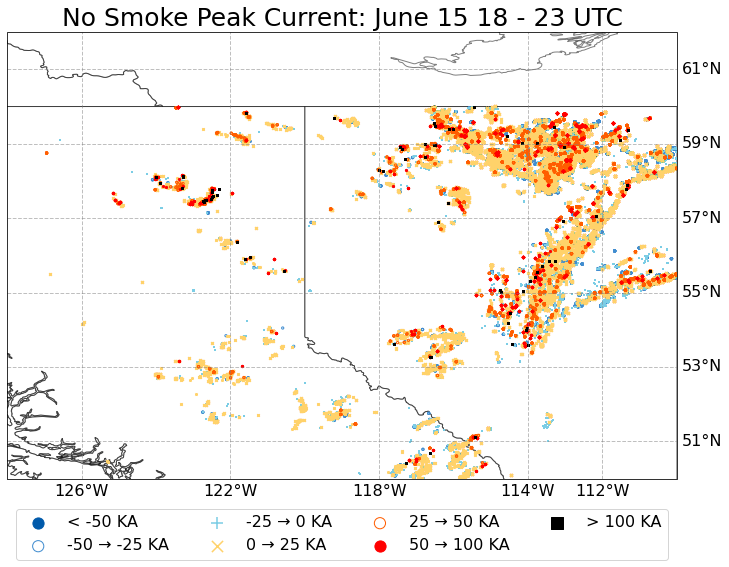

In [61]:
nosmoke_df = pd.read_csv("/data2/edworak/data/nosmoke_lightning_bt_closest.csv", sep='\t')

fig = plt.figure(figsize=(12,12))

#entire region
ax = plt.subplot(1,1,1 ,projection=ccrs.PlateCarree())
ax.set_extent([-128,-110,50,62])

ax.add_feature(cartopy.feature.BORDERS, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, linestyle = '-', alpha = 0.5)
ax.add_feature(cartopy.feature.COASTLINE, linestyle = '-', alpha = 0.5)

whole_points = nosmoke_df.loc[(nosmoke_df.hour >= 18) & (nosmoke_df.hour <= 23)] # june15.l_lon >= -128) & (june15.l_lon <= -110) & (june15.lat >= 50) & (june15.lat <= 65) &
whole_darkblue = (whole_points.loc[(whole_points["peak-current"] <= -50) & (whole_points.hour == 0)])
whole_medblue = (whole_points.loc[ (whole_points["peak-current"] > -50 ) & (whole_points["peak-current"] <=-25 )])
whole_lightblue = (whole_points.loc[ (whole_points["peak-current"] > -25 ) & (whole_points["peak-current"] <=0 )])
whole_lightorange = (whole_points.loc[(whole_points["peak-current"] > 0 ) & (whole_points["peak-current"] <=25 )])
whole_darkorange = (whole_points.loc[ (whole_points["peak-current"] > 25 ) & (whole_points["peak-current"] <=50 ) ])
whole_red = (whole_points.loc[ (whole_points["peak-current"] > 50 ) & (whole_points["peak-current"] <=100 )])
whole_black = (whole_points.loc[(whole_points["peak-current"] > 100 ) ])

plt.scatter(x = whole_darkblue["l_lon"], y = whole_darkblue["l_lat"], facecolors='#005AAB', edgecolors='#005AAB', marker = "o", s = 5,  alpha=1, label = '< -50 KA')
plt.scatter(x = whole_medblue["l_lon"], y = whole_medblue["l_lat"], facecolors='none', s = 5, edgecolors='#418DD0', marker = "o",  alpha=1, label='-50 → -25 KA')
plt.scatter(x = whole_lightblue["l_lon"], y = whole_lightblue["l_lat"], c = "#7BCDE5", marker = "+", s = 5,  alpha=1, label='-25 → 0 KA')
plt.scatter(x = whole_lightorange["l_lon"], y = whole_lightorange["l_lat"], c = "#FFD26A", marker = "x", s = 5,  alpha=1, label = "0 → 25 KA")
plt.scatter(x = whole_darkorange["l_lon"], y = whole_darkorange["l_lat"], facecolors = "none", edgecolors = '#FF5D00', marker = "o", s = 5,  alpha=1, label ="25 → 50 KA" )
plt.scatter(x = whole_red["l_lon"], y = whole_red["l_lat"], facecolors = "r", edgecolors = 'r', marker = "o", s = 5,  alpha=1, label = "50 → 100 KA")
plt.scatter(x = whole_black["l_lon"], y = whole_black["l_lat"], c = "black", marker = "s", s = 5,  alpha=1, label = "> 100 KA")

#nosmoke_subregion_box(ax, points_pos)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-126, -122,  -118, -114, -112])
gl.ylocator = mticker.FixedLocator([ 51,  53,  55,  57,  59, 61])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16, 'color': 'black'}
gl.ylabel_style = {'size': 16, 'color': 'black'} #, 'weight': 'bold'

plt.legend(loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=4, fancybox=True, shadow=False, fontsize = 16, markerscale=5.)

tight_layout = True
plt.title("Peak Current June 15 18 - 23 UTC", fontsize = 25)
plt.title("No Smoke Peak Current: June 15 18 - 23 UTC", fontsize =25)
plt.savefig("lightning_strength_nosmoke_bt", bbox_inches = "tight", dpi = 400)
plt.show()


## filter lightning_df

In [51]:
nosmoke_df = pd.read_csv("/data2/edworak/data/nosmoke_lightning_bt_closest.csv", sep='\t')

nosmoke_bt_df = nosmoke_df.loc[(nosmoke_df.CMI_C14 < -25)]
nosmoke_bt_df
# why is 27 the minimum bt 

,Unnamed: 0,year,month,day,hour,minute,second,l_lat,l_lon,peak-current,C or G,CMI_C14,bt_lat,bt_lon,distance
221,221,2021,6,15,18,1,3.939075,54.6388,-113.2773,-14.9,G,-27.27327,59.881268,-114.510895,587.610
222,222,2021,6,15,18,1,3.939075,54.6388,-113.2773,-14.9,G,-27.27327,58.123400,-112.786010,388.646
223,223,2021,6,15,18,1,3.939075,54.6388,-113.2773,-14.9,G,-27.27327,57.821404,-111.733635,366.501
224,224,2021,6,15,18,1,3.939075,54.6388,-113.2773,-14.9,G,-27.27327,57.298622,-111.910690,307.726
225,225,2021,6,15,18,1,3.939075,54.6388,-113.2773,-14.9,G,-27.27327,57.305637,-110.577600,340.753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747548,40718,2021,6,15,23,58,26.323227,59.4384,-114.4102,13.1,G,-27.27327,57.392120,-110.041230,341.220
747549,40719,2021,6,15,23,58,26.323227,59.4384,-114.4102,13.1,G,-27.27327,54.891190,-116.603460,522.559
747550,40720,2021,6,15,23,58,26.323227,59.4384,-114.4102,13.1,G,-27.27327,54.898026,-116.488754,520.119
747551,40721,2021,6,15,23,58,26.323227,59.4384,-114.4102,13.1,G,-27.27327,53.294872,-116.008090,690.129


## stats 

In [ ]:
positive = (nosmoke_bt_df[(nosmoke_bt_df["peak-current"] > 0) & nosmoke_bt_df["C or G"] == "G"])["peak-current"])


## no smoke histogram

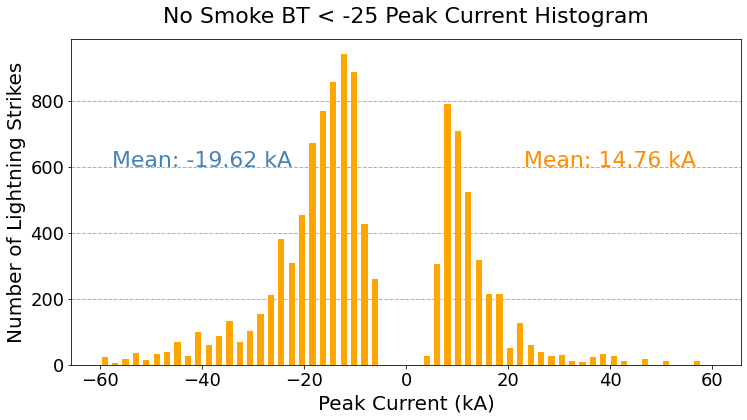

In [54]:
fig = plt.figure(figsize=(12,6))

weights = np.ones_like(nosmoke_bt_df["peak-current"]) / len(nosmoke_bt_df["peak-current"])

colors = ["orange"]

bins = np.linspace(-60, 60, 60)
plt.hist([nosmoke_bt_df["peak-current"]], bins, alpha = 1, histtype='bar', color=colors, rwidth=0.6) 

plt.grid(axis='y', linestyle='--', linewidth=1)
plt.title("No Smoke BT < -25 Peak Current Histogram", fontsize = 22, y = 1.03)
plt.xlabel("Peak Current (kA)", fontsize = 20)
plt.ylabel("Number of Lightning Strikes", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)

#nosmoke_bt_array = np.array([nosmoke_bt_df["peak-current"]])
# nosmoke_bt_pos = nosmoke_bt_df.loc([nosmoke_bt_df["peak-current"]>0])
# nosmoke_bt_pos_array = np.array(nosmoke_bt_pos)
# nosmoke_bt_neg = nosmoke_bt_df.loc([nosmoke_bt_df["peak-current"]<0])
# nosmoke_bt_neg_array = np.array(nosmoke_bt_neg)

plt.annotate("Mean: {:.2f} kA".format(np.mean(nosmoke_bt_df[nosmoke_bt_df["peak-current"] < 0]["peak-current"])), xy =(-40, 600), fontsize = 22, color = "steelblue", ha='center')
plt.annotate("Mean: {:.2f} kA".format(np.mean(nosmoke_bt_df[nosmoke_bt_df["peak-current"] > 0]["peak-current"])), xy =(40, 600), fontsize = 22, color = "darkorange", ha='center')

#plt.ylim(0, 4500)
plt.savefig("nosmoke_histogram_bt", dpi = 200)
dpi = 400
plt.show()

## timeseries

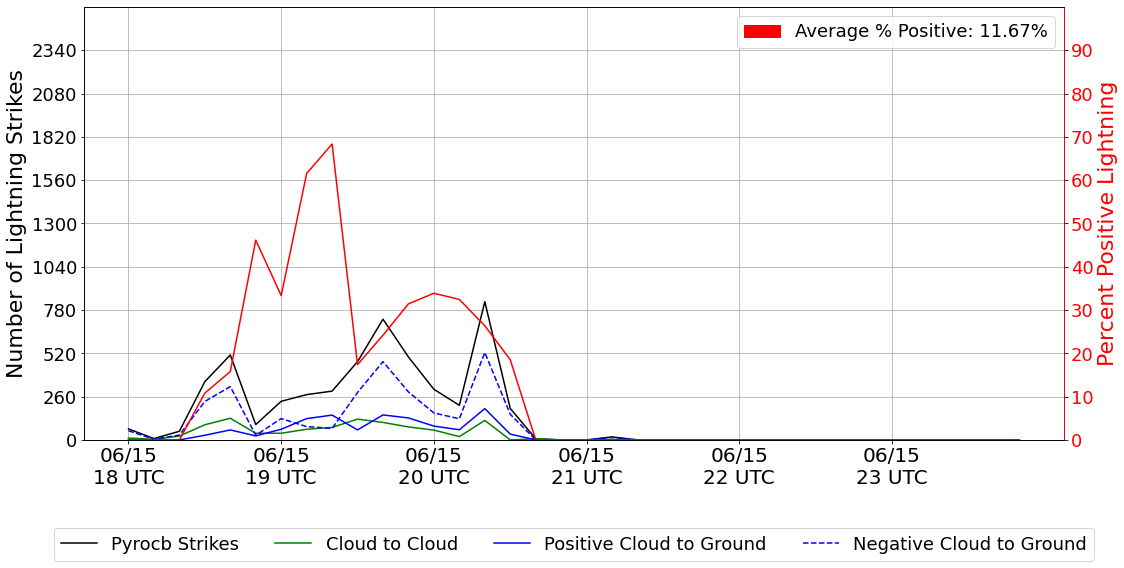

In [63]:

fig,ax = plt.subplots(figsize=(16,8))

xValues = np.arange(0, 36, 1)
xticks = np.arange(0, 36, 6)
yticks = np.arange(0, 2600, 260)
# plt.plot(time (x axis), number of lightning strikes (y axis) , color and line style, label = "label")

ax.plot(xValues, d15["num_strikes_nosmoke"], "k-", label = "Pyrocb Strikes")
ax.plot(xValues, d15["cloud_nosmoke"], "g", label = "Cloud to Cloud")
ax.plot(xValues, d15["pos_cloud_ground_nosmoke"], "b", label = "Positive Cloud to Ground")
ax.plot(xValues, d15["neg_cloud_ground_nosmoke"], "b--", label = "Negative Cloud to Ground")

ax.set_ylim((0,2600))
#ax.set_xlabel("Date and Time", fontsize = 18)
ax.set_ylabel("Number of Lightning Strikes", fontsize = 22)
# ax.legend(loc = "upper left", fontsize = 18)
plt.legend( loc='lower center', 
    bbox_to_anchor=(0.5, -0.3),
    ncol=4, fancybox=True, shadow=False, fontsize = 18, markerscale=3.,)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
labels = ["06/15 18 UTC","06/15 19 UTC", "06/15 20 UTC", "06/15 21 UTC", "06/15 22 UTC", "06/15 23 UTC"]
labels = ['\n'.join(wrap(l, 6)) for l in labels]
ax.set_xticklabels(labels, fontsize = 20)
ax.set_yticklabels(yticks, fontsize = 18)
plt.grid()

yticks2 = np.arange(0, 100, 10)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(xValues, d15["percent_pos_current_cloud_ground_nosmoke"], color="red")
ax2.set_ylabel("Percent Positive Lightning", color="red",fontsize=22)
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2, fontsize = 18,  color="red")
ax2.set_ylim((0,100))
ax2.spines['right'].set_color('red')

red_patch = mpatches.Patch(color='red', label='Average % Positive: {:.2f}%'.format(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])))
plt.legend(handles=[red_patch], fontsize = 18)


#plt.grid()
plt.tight_layout()
#plt.title("Vaisala Smoke Cloud and Cloud to Ground Lightning", y=1.01, fontsize = 20) 

plt.savefig("nosmoke_timeseries_bt.png", bbox_inches = "tight", dpi = 500)


## box and whisker 

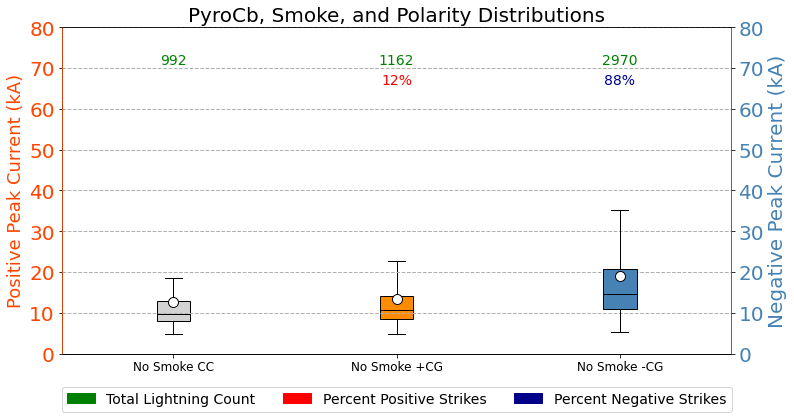

In [66]:
fig, ax = plt.subplots(figsize = (12,6))

ax.set_title('PyroCb, Smoke, and Polarity Distributions', fontsize = 20)
ax.set_ylabel("Positive Peak Current (kA)", color = "orangered", fontsize = 18)
plt.yticks(fontsize = 20)
plt.ylim(0, 80)
plt.yticks(fontsize = 20, color = "orangered")

data = [ list(map(abs,nosmoke_cloud_flat)), nosmoke_pos_ground_flat]

box1 = ax.boxplot(data, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [0, 1]) # , positions = [0, 2, 4, 6]

yticks2 = np.arange(0, 80, 8)
ax2=ax.twinx()

data2 = [list(map(abs,nosmoke_neg_ground_flat))] 
box2 = ax2.boxplot(data2, showfliers=False, showmeans = True, patch_artist=True, meanprops={"marker":"o",
                   "markerfacecolor":"white", 
                   "markeredgecolor":"black",
                  "markersize":"10"}, medianprops=dict(color='black'), positions = [2]) # 

ax2.set_ylabel("Negative Peak Current (kA)", color="steelblue",fontsize=20)

plt.yticks(fontsize = 20, color = "steelblue")
plt.ylim(0, 80)
ax2.spines['right'].set_color('steelblue')
ax2.spines['left'].set_color('orangered')

color1 = ['lightgray', 'darkorange'] 
for patch, color in zip(box1['boxes'], color1):
    patch.set_facecolor(color)

color2 = ['steelblue']
for patch, color in zip(box2['boxes'], color2):
    patch.set_facecolor(color)
        
labels = ["No Smoke CC", "No Smoke +CG", "No Smoke -CG"]  
ax.set_xticklabels(labels, fontsize = 12)


# nosmoke length count 
plt.annotate("{:.0f}".format(len(nosmoke_cloud_flat)), xy =(0, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_pos_ground_flat)), xy =(1, 71), fontsize = 14, color = "green", ha='center')
plt.annotate("{:.0f}".format(len(nosmoke_neg_ground_flat)), xy =(2, 71), fontsize = 14, color = "green", ha='center')

# nosmoke percentage 
plt.annotate("{:.0f}%".format(np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])), xy =(1, 66), fontsize = 14, color = "red", ha='center')
plt.annotate("{:.0f}%".format(100 - np.mean(d15["percent_pos_current_cloud_ground_nosmoke"])), xy =(2, 66), fontsize = 14, color = "darkblue", ha='center')

green_patch = mpatches.Patch(color='green', label='Total Lightning Count')
red_patch = mpatches.Patch(color='red', label='Percent Positive Strikes')
blue_patch = mpatches.Patch(color='darkblue', label='Percent Negative Strikes')

plt.legend(handles=[green_patch, red_patch, blue_patch], fontsize = 14,loc='lower center', 
           bbox_to_anchor=(0.5, -0.2),
          ncol=3, fancybox=True, shadow=False)
plt.grid(linestyle='--', linewidth=1) 
plt.savefig("boxplot_posneg_bt.png",bbox_inches = "tight", dpi = 800)
plt.show()
